In [14]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
#export
from exp.nb_02 import *
import sys, PIL, matplotlib.pyplot as plt, itertools, math, random, collections, torch
import scipy.stats, scipy.special

from enum import Enum, IntEnum
from torch import tensor, Tensor, FloatTensor, LongTensor, ByteTensor, DoubleTensor, HalfTensor, ShortTensor
from operator import itemgetter, attrgetter
from numpy import cos, sin, tan, tanh, log, exp
from dataclasses import field
from functools import reduce
from collections import defaultdict, abc, namedtuple, Iterable
from typing import Tuple, Hashable, Mapping, Dict

import mimetypes, abc, functools
from abc import abstractmethod, abstractproperty

D:\narain\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if sys.path[0] == '':


In [6]:
data_path.ls()

(#3) [d:\git\dl\data\imagenette2-160,d:\git\dl\data\imagewoof2-160,d:\git\dl\data\mnist.pkl.gz]

In [10]:
imagenette_path=data_path/'imagenette2-160'
imagenette_train=imagenette_path/'train'
imagenette_path.ls(), imagenette_train.ls()

((#3) [d:\git\dl\data\imagenette2-160\imagenette2-160.tar,d:\git\dl\data\imagenette2-160\train,d:\git\dl\data\imagenette2-160\val],
 (#10) [d:\git\dl\data\imagenette2-160\train\n01440764,d:\git\dl\data\imagenette2-160\train\n02102040,d:\git\dl\data\imagenette2-160\train\n02979186,d:\git\dl\data\imagenette2-160\train\n03000684,d:\git\dl\data\imagenette2-160\train\n03028079,d:\git\dl\data\imagenette2-160\train\n03394916,d:\git\dl\data\imagenette2-160\train\n03417042,d:\git\dl\data\imagenette2-160\train\n03425413,d:\git\dl\data\imagenette2-160\train\n03445777,d:\git\dl\data\imagenette2-160\train\n03888257])

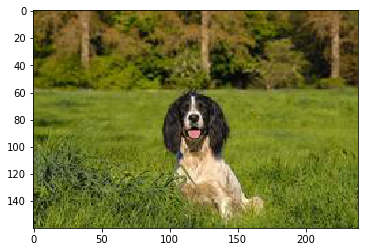

In [18]:
dog_path=imagenette_train.ls()[1]
img_god=img_1.ls()[1]
dog_img=PIL.Image.open(img_11)
plt.imshow(dog_img)

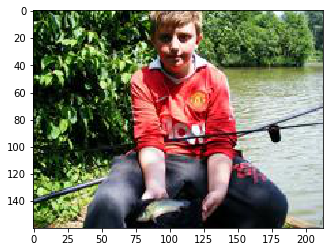

In [22]:
tench_path=imagenette_train.ls()[0]
img_tench=img_2.ls()[2]
tench_img=PIL.Image.open(img_21)
plt.imshow(tench_img)

In [23]:
#export 

def img2np(image: Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style"
    res = image.cpu().permute(1,2,0).numpy()
    return res[...,0] if res.shape[2]==1 else res

def show_image(img:Tensor, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, 
               title:Optional[str]=None, cmap:str='binary', alpha:Optional[float]=None)->plt.Axes:
    "Plot tensor `img` using matplotlib axis `ax`.  `figsize`,`axis`,`title`,`cmap` and `alpha` pass to `ax.imshow`"
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img), cmap=cmap, alpha=alpha)
    if hide_axis: ax.axis('off')
    if title: ax.set_title(title)
    return ax

In [24]:
class Image():
    def __init__(self, px): self.px = px
    def show(self, ax=None, **kwargs): return show_image(self.px, ax=ax, **kwargs)
    @property
    def data(self): return self.px

In [68]:
#export
FilePathList= Collection[Union[np.ndarray, L]]
TensorImage= Tensor
NPImage=np.ndarray

def find_classes(folder: Path)-> FilePathList:
    'return class subdirectories in imagenet style train folder'
    classes=L([d for d in folder.iterdir()
            if d.is_dir() and not d.name.startswith('.')])
    assert(len(classes)>0)
    return L(sorted(classes, key=lambda d:d.name))
#     return classes.sort(key=Lambda d:d.name)

image_extensions=set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

def get_image_files(c:Path, check_ext:bool=True)->FilePathList:
    'return list of files in c that are images, `check_ext` will filter to image extensions'
    return L([o for o in (c.iterdir())
           if not (o.name.startswith('.')) or o.is_dir()
           or (check_ext and o.suffix not in image_extensions)])

def pil2tensor(image:NPImage)->TensorImage:
    'convert PIL style `image` array to torch style image tensor `get_image_files`'
    arr=torch.ByteTensor(torch.ByteStorate.from_buffer(image.tobytes()))
    arr=arr.view(image.size[1], image.size[0], -1)
    return arr.permute(2,0,1)

PathOrStr=Union[Path, str]
def open_image(fn: PathOrStr):
    'return `image` object created from image in file `fn`'
    x=PIL.Image.open(fn).convert('RGB')
    return Image(pil2tensor(x).float().div_(255))

In [69]:
get_image_files(dog_path)

(#955) [d:\git\dl\data\imagenette2-160\train\n02102040\ILSVRC2012_val_00000665.JPEG,d:\git\dl\data\imagenette2-160\train\n02102040\ILSVRC2012_val_00001968.JPEG,d:\git\dl\data\imagenette2-160\train\n02102040\ILSVRC2012_val_00002294.JPEG,d:\git\dl\data\imagenette2-160\train\n02102040\ILSVRC2012_val_00002315.JPEG,d:\git\dl\data\imagenette2-160\train\n02102040\ILSVRC2012_val_00004548.JPEG,d:\git\dl\data\imagenette2-160\train\n02102040\ILSVRC2012_val_00004553.JPEG,d:\git\dl\data\imagenette2-160\train\n02102040\ILSVRC2012_val_00007568.JPEG,d:\git\dl\data\imagenette2-160\train\n02102040\ILSVRC2012_val_00008334.JPEG,d:\git\dl\data\imagenette2-160\train\n02102040\ILSVRC2012_val_00010994.JPEG,d:\git\dl\data\imagenette2-160\train\n02102040\ILSVRC2012_val_00012689.JPEG...]

In [70]:
find_classes(imagenette_train)

(#10) [d:\git\dl\data\imagenette2-160\train\n01440764,d:\git\dl\data\imagenette2-160\train\n02102040,d:\git\dl\data\imagenette2-160\train\n02979186,d:\git\dl\data\imagenette2-160\train\n03000684,d:\git\dl\data\imagenette2-160\train\n03028079,d:\git\dl\data\imagenette2-160\train\n03394916,d:\git\dl\data\imagenette2-160\train\n03417042,d:\git\dl\data\imagenette2-160\train\n03425413,d:\git\dl\data\imagenette2-160\train\n03445777,d:\git\dl\data\imagenette2-160\train\n03888257]

In [71]:
isinstance(L, Collection)

False

In [72]:
#export
NPArrayableList= Collection[Union[np.ndarray, L]]
NPArrayMask=np.ndarray
SplitArrayList=L([Tuple[np.ndarray, np.ndarray]])

def arrays_split(maskLNPArrayMask, *arrs:NPArrayableList)->SplitArrayList:
    'Given `arrs` is [a,b,...] and `mask` index - return [(a[mask], a[-mask]), (b[mask],b[~mask]),...]'
    mask=array(mask)
    return list(zip(*[(a[mask],a[~mask]) for a in map(np.array, arrs)]))

def random_split(valid_pct:float, *arrs:NPArraybleList)->SplitArrayList:
    'randomly `array_split` with `valid_pct` ratio good for creating validation set'
    is_train=np.random.uniform(size=(len(arrs[0]),))>valid_pct
    return arrays_split(is_train, *arrs)

class DatasetBase(Dataset):
    'Base class for all datasets'
    def __len__(self): return len(self.x)
    @property
    def c(self):
        'number of variable expressed by `y` variable'
        return self.y.shape[-1] if len(self.y.shape)>1 else 1
    def __repr__(self): return f'{type(self).__name__} if len {len(self)}'
    
class LabelDataset(DatasetBase):
    'Base class for datasets for classification'
    @property
    def c(self):
        'number of classes expressed by dataset y variable'
        return len(self.classes)

In [77]:
ImgLabel=str
ImgLabels= Collection[ImgLabel]
Classes= Collection[Any]

class ImageDataset(LabelDataset):
    'Dataset for folders of images in style {folder}/{class}/{images}'
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Classes]=None):
        self.classes=ifnone(classes, L(set(labels)))
        self.class2idx= {v:k for k,v in enumerate(self.classes)}
        self.x=np.array(fns)
        self.y=np.array([self.class2idx[o] for o in labels], dtype=np.int64)
        
    def __getitem__(self, i): return open_image(self.x[i]), self.y[i]
    
    @staticmethod
    def _folder_files(folder:Path, label:ImgLabel, check_ext=True)->Tuple[FilePathList, ImgLabels]:
        'from `folder` return image files and labels the labels are all `label`, `check_ext` means only image files'
        fnames=get_image_files(folder, check_ext=check_ext)
        return fnames, [label]*len(fnames)
    
    @classmethod
    def from_single_folder(cls, folder:PathOrStr, classes:Classes, check_ext=True):
        "Typically used for test set. label all images in `folder` with `classes[0]`"
        fns,labels = cls._folder_files(folder, classes[0], check_ext=check_ext)
        return cls(fns, labels, classes=classes)
    
    @classmethod
    def from_folder(cls, folder:Path, classes:Optional[Classes]=None,
                   valid_pct:float=0.,check_ext:bool=True)->Union['ImageDataset', List['ImageDataset']]:
        'Dataset of `classes` labeled images in `folder` Optional` `valid_pct` split validation set'
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
            
        fns, labels=[],[]
        for cl in classes:
            f,l =cls._folder_files(folder/cl,cl,check_ext=check_ext)
            fns+=f;labels+=l
            
        if valid_pct==0:
            return cls(fns, labels, classes=classes)
        return [cls(*a, classes=classes) for a in random_split(valid_pct, fns, labels)]

In [78]:
ImageDataset.from_folder(imagenette_train)

ImageDataset if len 9469